In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset_builder
from datasets import load_dataset
from datasets.arrow_dataset import Dataset

from keras_hub.models import BertTextClassifier
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Using tensorflow: {}".format(tf.__version__))

2025-09-06 10:20:27.203428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757154027.395296      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757154027.456096      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using tensorflow: 2.18.0


### Connect to an accelerator

In [2]:
try:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("Using Tpu")
except:
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Using GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print("Using CPU")

Using GPU


I0000 00:00:1757154041.874509      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Inspect dataset

In [3]:
ds_builder = load_dataset_builder("sh0416/ag_news")

README.md: 0.00B [00:00, ?B/s]

In [4]:
ds_builder.info

DatasetInfo(description='', citation='', homepage='', license='', features={'label': Value(dtype='int64', id=None), 'title': Value(dtype='string', id=None), 'description': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, builder_name='json', dataset_name='ag_news', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=30177303, num_examples=120000, shard_lengths=None, dataset_name='ag_news'), 'test': SplitInfo(name='test', num_bytes=1902274, num_examples=7600, shard_lengths=None, dataset_name='ag_news')}, download_checksums={'hf://datasets/sh0416/ag_news@70e3fa1915be9a8daebec5e840f20df9a8e18793/train.jsonl': {'num_bytes': 33697315, 'checksum': None}, 'hf://datasets/sh0416/ag_news@70e3fa1915be9a8daebec5e840f20df9a8e18793/test.jsonl': {'num_bytes': 2125097, 'checksum': None}}, download_size=35822412, post_processing_size=None, dataset_size=32079577, size_in_bytes=67901989)

In [5]:
ds_builder.info.features

{'label': Value(dtype='int64', id=None),
 'title': Value(dtype='string', id=None),
 'description': Value(dtype='string', id=None)}

In [6]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=30177303, num_examples=120000, shard_lengths=None, dataset_name='ag_news'),
 'test': SplitInfo(name='test', num_bytes=1902274, num_examples=7600, shard_lengths=None, dataset_name='ag_news')}

In [7]:
dataset = load_dataset("sh0416/ag_news")

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 7600
    })
})


In [9]:
# Split train split into train_set and val_set
train_test_dataset = dataset["train"].train_test_split(test_size=0.2, shuffle=True, seed=42)
train_dataset = train_test_dataset["train"]
val_dataset = train_test_dataset["test"]

# Take test split as test_set
test_dataset = dataset["test"]

In [10]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['label', 'title', 'description'],
    num_rows: 96000
})
Dataset({
    features: ['label', 'title', 'description'],
    num_rows: 24000
})
Dataset({
    features: ['label', 'title', 'description'],
    num_rows: 7600
})


In [11]:
train_dataset.features

{'label': Value(dtype='int64', id=None),
 'title': Value(dtype='string', id=None),
 'description': Value(dtype='string', id=None)}

In [12]:
train_dataset[3]

{'label': 3,
 'title': 'Sirius Satellite Signs Howard Stern to 5-Year Accord (Update9)',
 'description': 'Howard Stern, host of the top-rated radio show for young men in New York and Los Angeles, will move to Sirius Satellite Radio Inc.'}

In [13]:
train_df = train_dataset.to_pandas()
val_df = val_dataset.to_pandas()
test_df = test_dataset.to_pandas()
train_df.head(10)

,label,title,description
0,3,Nation #39;s Cotton Crop May Exceed Records,This year #39;s cotton crop is on pace to be t...
1,2,18 years and still rollin #39;,ALEX FERGUSON will take up the one-year rollin...
2,2,Madrid Masters: Safin beats Nalbandian,Sunday #39;s final of the Madrid Masters pitte...
3,3,Sirius Satellite Signs Howard Stern to 5-Year ...,"Howard Stern, host of the top-rated radio show..."
4,4,"NATO, Russia To Meet Over Beslan School Siege",6 September 2004 -- NATO Secretary-General Jaa...
5,1,WTO Rules Against EU Protection of Goods (AP),AP - The United States and Australia prevailed...
6,4,A Low-Key Migration (washingtonpost.com),washingtonpost.com - Change is coming for AT T...
7,4,Google Plans Desktop Search Tool for Apple PCs,"Google Inc. (GOOG.O: Quote, Profile, Research)..."
8,1,Security tightened in Madhya Pradesh #39;s Cha...,Security has been tightened and alert sounded ...
9,2,Aussie equestrian hopes end in sixth,Australia #39;s dreams of an historic fourth s...


In [14]:
print("NaN values in train set:")
print(train_df.isna().sum())
print("\nNaN values in validation set:")
print(val_df.isna().sum())
print("\nNaN values in test set:")
print(test_df.isna().sum())

NaN values in train set:
label          0
title          0
description    0
dtype: int64

NaN values in validation set:
label          0
title          0
description    0
dtype: int64

NaN values in test set:
label          0
title          0
description    0
dtype: int64


In [15]:
def get_class_freq(dataset: Dataset) -> dict[str, int]:
    id_to_class = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
    class_ids, counts = np.unique(dataset["label"], return_counts=True)
    class_names = [id_to_class[_id] for _id in class_ids]
    return dict(zip(class_names, counts))

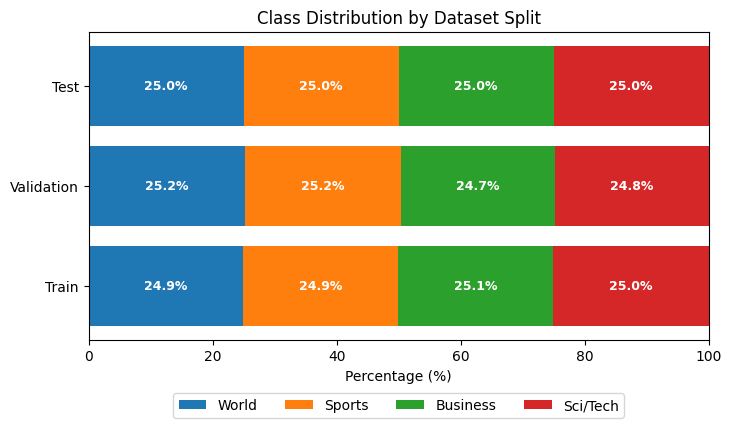

In [16]:
train_freq = get_class_freq(train_dataset)
val_freq   = get_class_freq(val_dataset)
test_freq  = get_class_freq(test_dataset)

splits = {"Train": train_freq, "Validation": val_freq, "Test": test_freq}

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8, 4))

for i, (split, freq_dict) in enumerate(splits.items()):
    total = sum(freq_dict.values())
    percentages = {k: v / total * 100 for k, v in freq_dict.items()}
    
    left = 0
    for (cls, pct), color in zip(percentages.items(), colors):
        plt.barh([split], [pct], left=left, color=color)
        plt.text(left + pct / 2, i, f"{pct:.1f}%", ha="center", va="center",
                 color="white", fontsize=9, fontweight="bold")
        left += pct

plt.xlabel("Percentage (%)")
plt.title("Class Distribution by Dataset Split")
plt.xlim(0, 100)
plt.legend(splits["Train"].keys(), loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [17]:
BATCH_SIZE = 128

tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["description"],
    label_cols=["label"],
    batch_size=BATCH_SIZE,
    shuffle=True
)

tf_val_dataset = val_dataset.to_tf_dataset(
    columns=["description"],
    label_cols=["label"],
    batch_size=BATCH_SIZE,
    shuffle=True
)

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [18]:
def adjust_labels(x, y):
    return x, y - 1  # shift [1,2,3,4] -> [0,1,2,3]

tf_train_dataset = tf_train_dataset.map(adjust_labels)
tf_val_dataset = tf_val_dataset.map(adjust_labels)

In [19]:
for key, value in tf_train_dataset.take(1):
    print(key)
    print("*" * 150)
    print(value)

tf.Tensor(
[b'Reuters - An earthquake has rocked a densely\\populated city in southwestern China, destroying more than\\20,000 houses but killing no one, a local official said on\\Wednesday.'
 b'AOL Places Classified Listings in Search Engine Results\\\\Although AOL has yet to launch their AOL InStore into their search engine results, according to AuctionBytes, AOL is now testing the inclusion of AOL Classified Ads into their normal Google powered search listings. The classified listings are now being tested in AOL ...'
 b'AP - Authorities said Friday they would kill the shark that tore apart a young surfer near a popular south Australian beach as his friends reportedly tried to save him by beating the animal with oars.'
 b'SPACE.com - Anyone looking for signs of extraterrestrial life need not look in the center of our galaxy.'
 b'CAIRO -- The Egyptian and Syrian presidents linked calls by the United Nations and Arab leaders for Syrian troops to leave Lebanon to past UN resolutions dem

### Build and train the model

In [20]:
BACKBONE = "bert_tiny_en_uncased"
NUM_CLASSES = 4
LEARNING_RATE = 5e-5
EPOCHS = 20

In [21]:
with strategy.scope():
    classifier = BertTextClassifier.from_preset(
        preset=BACKBONE,
        num_classes=NUM_CLASSES,
    )

    classifier.compile(
        loss=SparseCategoricalCrossentropy(name="sparse_categorical_loss", from_logits=True),
        metrics = [SparseCategoricalAccuracy(name="sparse_categorical_accuracy")],
        optimizer=Adam(LEARNING_RATE),
    )

    assert classifier.backbone.trainable == True

In [22]:
classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 4)                 │             516 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,436 (16.73 MB)

 Trainable params: 4,386,436 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    verbose=True,
    restore_best_weights=True,
)

In [24]:
history = classifier.fit(
    x=tf_train_dataset,
    epochs=EPOCHS,
    validation_data=tf_val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 140s 177ms/step - loss: 0.7739 - sparse_categorical_accuracy: 0.7751 - val_loss: 0.3090 - val_sparse_categorical_accuracy: 0.9024
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - loss: 0.3018 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.2758 - val_sparse_categorical_accuracy: 0.9085
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 133s 176ms/step - loss: 0.2511 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.2573 - val_sparse_categorical_accuracy: 0.9131
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - loss: 0.2161 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9159
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.2483 - val_sparse_categorical_accuracy: 0.9174
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 133s 176ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.2519 - val_sparse_categoric

In [25]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


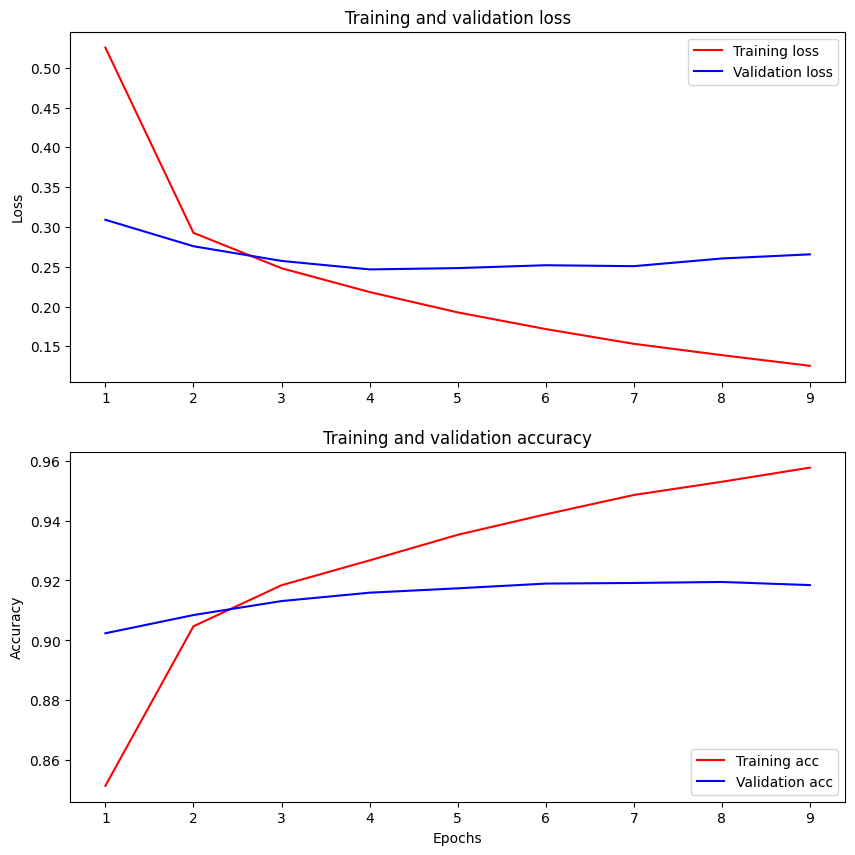

In [26]:
history_dict = history.history

acc = history_dict["sparse_categorical_accuracy"]
val_acc = history_dict["val_sparse_categorical_accuracy"]
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Evaluate on test set

In [27]:
tf_test_dataset = test_dataset.to_tf_dataset(
    columns=["description"],
    label_cols=["label"],
    batch_size=BATCH_SIZE,
    shuffle=True
)

tf_test_dataset = tf_test_dataset.map(adjust_labels)

In [28]:
classifier.evaluate(tf_test_dataset)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.2697 - sparse_categorical_accuracy: 0.9096


[0.25955134630203247, 0.913947343826294]

### Export for inferencing

In [29]:
saved_model_path = "./news_clf_model.keras"
classifier.save(saved_model_path)

reloaded_model = tf.keras.models.load_model(saved_model_path)
reloaded_model.evaluate(tf_test_dataset)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1757155263.395367      96 service.cc:148] XLA service 0x15ea3400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757155263.396145      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capabil

 6/60 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2746 - sparse_categorical_accuracy: 0.9241

I0000 00:00:1757155264.489574      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.2508 - sparse_categorical_accuracy: 0.9185


[0.2595512568950653, 0.913947343826294]

In [30]:
prod_data = [
    'WASHINGTON (Reuters) - Sales of existing U.S. homes fell  more than expected in July, as the housing market took a  breather from its record-toppling run, a trade association  report showed on Tuesday.',
    'An Irish political party leader is to urge British Prime Minister Tony Blair to accelerate the withdrawal of troops from republican areas of Northern Ireland.',
    'Former Enron Corp. chairman Kenneth L. Lay, who for weeks had been pressing to be tried on his own on criminal charges related to the company #39;s demise, yesterday got more than he bargained for.',
    'AP - American defender Steve Cherundolo scored the second goal of the game in the 53rd minute Sunday, helping Hannover 96 to a 3-0 victory at VfR Neumuenster in the first round of the German Cup.',
    'LONDON (Reuters) - Oil prices hovered below \\$47 a barrel on  Wednesday, awaiting U.S. data that was expected to show a big  drop in fuel stocks after Hurricane Ivan disrupted operations.'
]

logits = reloaded_model.predict(prod_data)
probabilities = tf.nn.softmax(logits, axis=-1)
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
tf.Tensor(
[[0.0048134  0.00146305 0.98572516 0.00799834]
 [0.9926553  0.00220652 0.00344953 0.00168868]
 [0.00610248 0.00116891 0.98189044 0.01083817]
 [0.00872555 0.9886475  0.00117675 0.00145012]
 [0.0095986  0.00138963 0.9846676  0.0043442 ]], shape=(5, 4), dtype=float32)


In [31]:
pred_class_ids = tf.argmax(probabilities, axis=-1)
print(pred_class_ids)

tf.Tensor([2 0 2 1 2], shape=(5,), dtype=int64)


In [32]:
pred_class_ids_adjusted = pred_class_ids + 1
id_to_class = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
predicted_classes = tf.constant([id_to_class[class_id] for class_id in pred_class_ids_adjusted.numpy()])
print(predicted_classes)

tf.Tensor([b'Business' b'World' b'Business' b'Sports' b'Business'], shape=(5,), dtype=string)
